In [29]:
import pandas as pd
import networkx as nx
from tabulate import tabulate
from networkx.readwrite import write_gexf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.metrics import mean_squared_error
import random
random.seed(42)


## Part 1: Getting the data ready

In [2]:

# Load the datasets
influence_data = pd.read_csv("Data/influence_data.csv")
data_by_artist = pd.read_csv("Data/data_by_artist.csv")

In [3]:
print(influence_data.head())

   influencer_id influencer_name influencer_main_genre  \
0         759491   The Exploited              Pop/Rock   
1          25462          Tricky            Electronic   
2          66915       Bob Dylan              Pop/Rock   
3          71209   Leonard Cohen              Pop/Rock   
4          91438    The Gun Club              Pop/Rock   

   influencer_active_start  follower_id   follower_name follower_main_genre  \
0                     1980           74  Special Duties            Pop/Rock   
1                     1990          335       PJ Harvey            Pop/Rock   
2                     1960          335       PJ Harvey            Pop/Rock   
3                     1950          335       PJ Harvey            Pop/Rock   
4                     1980          335       PJ Harvey            Pop/Rock   

   follower_active_start  
0                   1980  
1                   1990  
2                   1990  
3                   1990  
4                   1990  


In [4]:
# Create a dictionary for artist genres and years
artist_genres = dict(zip(influence_data['influencer_id'], influence_data['influencer_main_genre']))
artist_years = dict(zip(influence_data['influencer_id'], influence_data['influencer_active_start']))
artist_genres.update(dict(zip(influence_data['follower_id'], influence_data['follower_main_genre'])))
artist_years.update(dict(zip(influence_data['follower_id'], influence_data['follower_active_start'])))

This code snippet creates two dictionaries, artist_genres and artist_years, to store the main genre and active start year for each artist, respectively.

First, the zip() function is used to create pairs of influencer_id with influencer_main_genre and influencer_active_start. These pairs are then converted into dictionaries using the dict() function.
The first dictionary artist_genres has artist IDs as keys and their main genres as values.
The second dictionary artist_years has artist IDs as keys and their active start years as values.
Next, the code updates these dictionaries with the follower data. zip() is used again to create pairs of follower_id with follower_main_genre and follower_active_start.
The update() function is then used to add the new key-value pairs from followers to the existing dictionaries (artist_genres and artist_years). If a key (artist ID) is already present, its value will be updated with the new value from the follower data.
At the end of this code snippet, we will have two dictionaries containing main genre and active start year information for all artists (both influencers and followers) in the dataset.

In [5]:
# Create the directed graph
G = nx.DiGraph()

# Add nodes with attributes
for idx, row in data_by_artist.iterrows():
    artist_id = row["artist_id"]
    G.add_node(artist_id, 
               artist_name=row["artist_name"], 
               genre=artist_genres.get(artist_id, ''), 
               year=artist_years.get(artist_id, ''),
               danceability=row["danceability"],
               energy=row["energy"],
               valence=row["valence"],
               tempo=row["tempo"],
               loudness=row["loudness"],
               acousticness=row["acousticness"],
               instrumentalness=row["instrumentalness"],
               liveness=row["liveness"],
               speechiness=row["speechiness"],
               duration_ms=row["duration_ms"],
               popularity=row["popularity"])

In [6]:
# Add edges with attributes
for idx, row in influence_data.iterrows():
    influencer_id = row["influencer_id"]
    follower_id = row["follower_id"]

    if G.has_node(influencer_id) and G.has_node(follower_id):
        # Calculate differences in attributes
        attr_diff = {}
        for attr in ["danceability", "energy", "valence", "tempo", "loudness",
                     "acousticness", "instrumentalness", "liveness", "speechiness",
                     "duration_ms", "popularity"]:
            attr_diff[attr + "_diff"] = abs(G.nodes[influencer_id][attr] - G.nodes[follower_id][attr])

        # Add the edge with attribute differences
        G.add_edge(influencer_id, follower_id, **attr_diff)

In [7]:
# Print the number of nodes and edges in the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Print information about a specific node
node_id = 2732005  # Replace this with an actual artist ID from your dataset
if G.has_node(node_id):
    print(f"Node {node_id} attributes: {G.nodes[node_id]}")
else:
    print(f"Node {node_id} not found in the graph")

# Print information about a specific edge
source_id = 759491 # Replace this with an actual influencer ID from your dataset
target_id = 74  # Replace this with an actual follower ID from your dataset
if G.has_edge(source_id, target_id):
    print(f"Edge ({source_id}, {target_id}) attributes: {G.edges[source_id, target_id]}")
else:
    print(f"Edge ({source_id}, {target_id}) not found in the graph")


Number of nodes: 5854
Number of edges: 42752
Node 2732005 attributes: {'artist_name': 'Zendaya', 'genre': 'Pop/Rock', 'year': 2010, 'danceability': 0.5904375, 'energy': 0.707625, 'valence': 0.3544375, 'tempo': 116.249, 'loudness': -7.0725625, 'acousticness': 0.072864937, 'instrumentalness': 0.00351835, 'liveness': 0.23346875, 'speechiness': 0.0733625, 'duration_ms': 214595.125, 'popularity': 64.3125}
Edge (759491, 74) attributes: {'danceability_diff': 0.21628571399999996, 'energy_diff': 0.005428570999999938, 'valence_diff': 0.06771428600000001, 'tempo_diff': 18.563999999999993, 'loudness_diff': 0.289285714, 'acousticness_diff': 0.010574713999999999, 'instrumentalness_diff': 0.0021927789999999997, 'liveness_diff': 0.11625714299999998, 'speechiness_diff': 0.106171429, 'duration_ms_diff': 52475.71429999999, 'popularity_diff': 5.714285709999999}


In [8]:
# Save the graph in GEXF format for Gephi. We can directly import this into Gephi. 
# write_gexf(G, "influence_network.gexf")

In our orginal influence_data we have 42770 edges but the combined graph G has only 42752 edges as we can see below. 

In [9]:
influence_data_edges = {(row['influencer_id'], row['follower_id']) for _, row in influence_data.iterrows()}
graph_edges = set(G.edges)

print(f"Number of edges in influence_data: {len(influence_data_edges)}")
print(f"Number of edges in the graph: {len(graph_edges)}")

# Check for differences between the two sets of edges
missing_edges = influence_data_edges - graph_edges
if missing_edges:
    print(f"Missing edges in the graph: {missing_edges}")
else:
    print("All edges from influence_data are present in the graph.")


Number of edges in influence_data: 42770
Number of edges in the graph: 42752
Missing edges in the graph: {(642542, 477787), (483587, 477787), (58549, 477787), (182900, 477787), (41874, 477787), (139089, 477787), (162197, 477787), (43714, 477787), (87179, 477787), (754032, 477787), (129761, 477787), (100160, 477787), (790732, 477787), (51992, 477787), (501802, 477787), (61172, 477787), (582313, 477787), (489209, 477787)}


It appears that there are some edges present in the influence_data dataset that are not present in the graph. One possible reason for this discrepancy is that some of the artist IDs in the influence_data dataset do not have corresponding entries in the data_by_artist dataset. When we tried to merge the datasets, those rows were excluded, causing the edges to be missing from the graph.

To investigate this issue further, you can check if the artists involved in the missing edges are present in the data_by_artist dataset:

In [10]:
missing_artist_ids = set()

for edge in missing_edges:
    influencer_id, follower_id = edge
    if influencer_id not in data_by_artist['artist_id'].values:
        missing_artist_ids.add(influencer_id)
    if follower_id not in data_by_artist['artist_id'].values:
        missing_artist_ids.add(follower_id)

print(f"Missing artist IDs: {missing_artist_ids}")


Missing artist IDs: {477787}


It seems that the artist with ID 477787 is missing from the artist_data DataFrame, which is causing the discrepancy between the number of edges in the original influence_data and the exported graph. 
Upon investigating, the artist with ID 477787 is " The New Pornographers" which is included in the influence_data but does not have a record in data_by_artist. 

## Part 2 : Analyzing the influence
Examine the distribution of the differences in musical characteristics for all edges in the network to get an overall understanding of how artists influence each other.
Identify patterns of influence, such as which characteristics are more likely to be influenced or whether certain genres show stronger influence patterns than others.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns


To analyze the influence and identify patterns, we can use the network data and the edge attributes that store the differences in musical characteristics.

In [12]:
#Extract the differences in musical characteristics for all edges:
energy_diffs = []
valence_diffs = []
tempo_diffs = []

for edge in G.edges(data=True):
    energy_diffs.append(edge[2]['energy_diff'])
    valence_diffs.append(edge[2]['valence_diff'])
    tempo_diffs.append(edge[2]['tempo_diff'])


In this code snippet, we are iterating through all the edges in the graph G. The edges() method returns an iterator over the edges in the graph. By setting the data=True parameter, we get an edge view of the graph with edge attributes as a dictionary.

Here, edge is a tuple with three elements:

edge[0] is the source node (influencer) of the edge.
edge[1] is the target node (follower) of the edge.
edge[2] is a dictionary containing the edge attributes, which are the differences in musical characteristics between the influencer and the follower.

Here, we collect the differences in energy, valence, and tempo for all edges in the graph, so we can analyze the distribution of these differences later. This will give us insights into how the musical characteristics change between influencers and followers in the network.

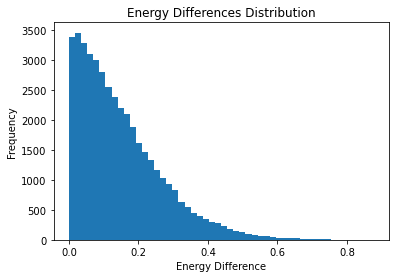

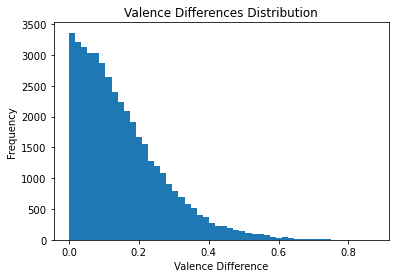

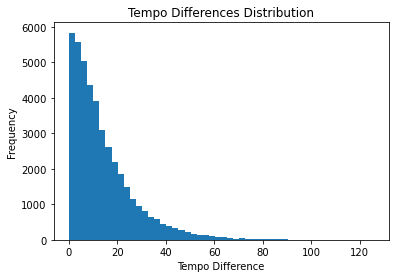

In [13]:
#Analyze the distribution of the differences.T
#This code will plot histograms for the differences of each attribute in the graph, allowing us to analyze the distribution of differences for all edges in the network.

plt.hist(energy_diffs, bins=50)
plt.title('Energy Differences Distribution')
plt.xlabel('Energy Difference')
plt.ylabel('Frequency')
plt.show()

plt.hist(valence_diffs, bins=50)
plt.title('Valence Differences Distribution')
plt.xlabel('Valence Difference')
plt.ylabel('Frequency')
plt.show()

plt.hist(tempo_diffs, bins=50)
plt.title('Tempo Differences Distribution')
plt.xlabel('Tempo Difference')
plt.ylabel('Frequency')
plt.show()


In [14]:
#Examine the influence patterns by genre


genre_influence = defaultdict(lambda: defaultdict(list))

for edge in G.edges(data=True):
    influencer_genre = artist_genres[edge[0]]
    genre_influence[influencer_genre]['energy_diff'].append(edge[2]['energy_diff'])
    genre_influence[influencer_genre]['valence_diff'].append(edge[2]['valence_diff'])
    genre_influence[influencer_genre]['tempo_diff'].append(edge[2]['tempo_diff'])

# Calculate the average difference in each characteristic by genre
genre_influence_summary = {}
for genre, influence_data in genre_influence.items():
    genre_influence_summary[genre] = {
        'avg_energy_diff': np.mean(influence_data['energy_diff']),
        'avg_valence_diff': np.mean(influence_data['valence_diff']),
        'avg_tempo_diff': np.mean(influence_data['tempo_diff']),
    }

# Display the results
for genre, summary in genre_influence_summary.items():
    print(f"{genre}: {summary}")


Vocal: {'avg_energy_diff': 0.16835961877157002, 'avg_valence_diff': 0.16896830338896748, 'avg_tempo_diff': 14.005173418330976}
Country: {'avg_energy_diff': 0.1671514653541351, 'avg_valence_diff': 0.13772586284610724, 'avg_tempo_diff': 13.47820823295668}
Pop/Rock: {'avg_energy_diff': 0.14233268728765078, 'avg_valence_diff': 0.149716472980102, 'avg_tempo_diff': 14.398816190492475}
Classical: {'avg_energy_diff': 0.23916003824561402, 'avg_valence_diff': 0.1821367202982456, 'avg_tempo_diff': 15.524527842280705}
Jazz: {'avg_energy_diff': 0.174469532326215, 'avg_valence_diff': 0.17241025937407953, 'avg_tempo_diff': 13.483138266222387}
International: {'avg_energy_diff': 0.1897133445304878, 'avg_valence_diff': 0.1892617012347561, 'avg_tempo_diff': 19.568003544939025}
Reggae: {'avg_energy_diff': 0.14063896522704716, 'avg_valence_diff': 0.11420023035856079, 'avg_tempo_diff': 19.11383389362283}
R&B;: {'avg_energy_diff': 0.12961361308336347, 'avg_valence_diff': 0.14598131300180833, 'avg_tempo_diff'

A better way to visualize the results would be to use a bar plot to display the average differences in each characteristic by genre.

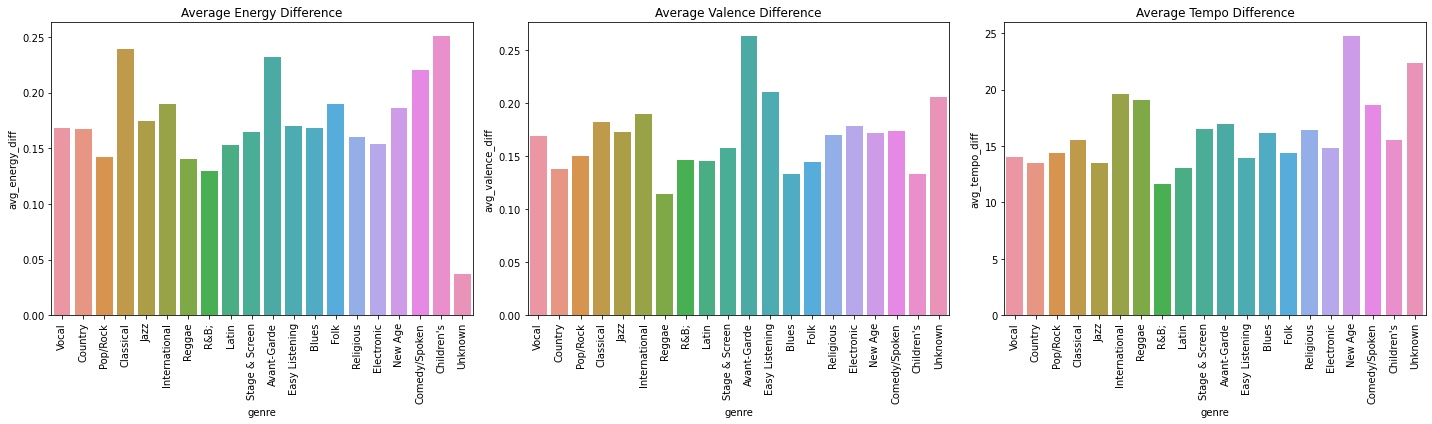

In [15]:

# Convert the genre_influence_summary to a pandas DataFrame
summary_df = pd.DataFrame(genre_influence_summary).T.reset_index().rename(columns={'index': 'genre'})

# Create a bar plot for each characteristic
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

sns.barplot(x='genre', y='avg_energy_diff', data=summary_df, ax=axes[0])
axes[0].set_title('Average Energy Difference')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

sns.barplot(x='genre', y='avg_valence_diff', data=summary_df, ax=axes[1])
axes[1].set_title('Average Valence Difference')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

sns.barplot(x='genre', y='avg_tempo_diff', data=summary_df, ax=axes[2])
axes[2].set_title('Average Tempo Difference')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()


The insights derived from the bar plots would help us understand the patterns of influence among different genres in terms of the average differences in musical characteristics (energy, valence, and tempo). Specifically, you would be able to identify:

The extent of influence: By observing the height of the bars in the plots, we can determine how much influence one genre has on others. Larger average differences may indicate a weaker influence, while smaller average differences could suggest a stronger influence.

Genre-specific trends: By comparing the bars across different genres, we can identify which genres have a stronger influence on their followers in terms of specific musical characteristics. For instance, if a certain genre consistently shows small average differences across energy, valence, and tempo, it may be a highly influential genre in the music industry.

Characteristics prone to influence: By comparing the average differences across the three characteristics (energy, valence, and tempo), we can identify which characteristics are more likely to be influenced. For example, if the average differences for energy are generally smaller than those for valence and tempo, it could suggest that energy is a characteristic that is more likely to be influenced by other artists.
These insights can help us better understand how artists from different genres influence each other's music and which musical characteristics are more susceptible to influence. Additionally, this analysis can provide a basis for further exploration, such as investigating the reasons behind specific influence patterns or examining other factors that may affect the strength of influence, such as the time period or artist popularity.

The extent of influence refers to the degree to which one artist's music has an impact on the music of another artist, particularly in terms of specific musical characteristics. In this case, we are examining energy, valence, and tempo. When we calculate the average differences in these characteristics between influencer and follower artists, we can gauge the extent of influence.

If the average differences are smaller, it suggests that the follower's music is closer in characteristics to that of the influencer, indicating a stronger influence. In other words, the follower has likely been more heavily influenced by the music of the influencer, resulting in similar musical characteristics.

On the other hand, if the average differences are larger, it means that the music of the follower is more dissimilar to that of the influencer in terms of the examined characteristics. This suggests a weaker influence, as the follower's music may be less impacted by the influencer's music, resulting in greater disparities in characteristics.

By observing the height of the bars in the plots, you can visualize these average differences and determine the extent of influence across genres. Shorter bars represent smaller average differences and therefore stronger influence, while taller bars indicate larger average differences and weaker influence. Comparing these bars allows you to identify which genres have stronger or weaker influences on others in terms of the specific musical characteristics being analyzed.

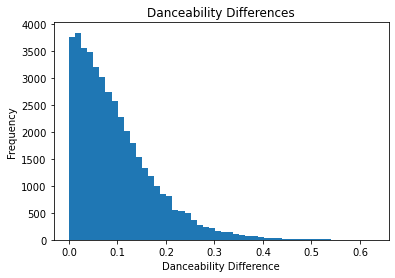

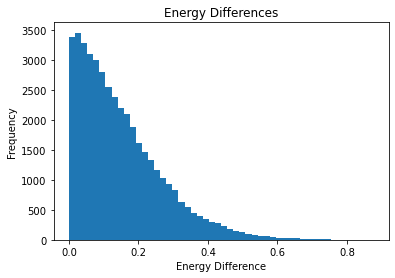

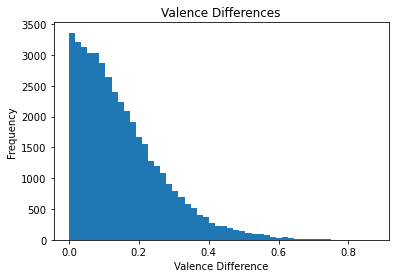

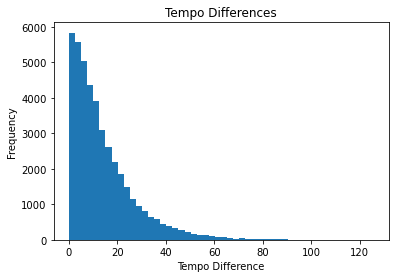

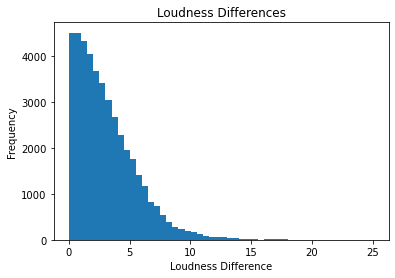

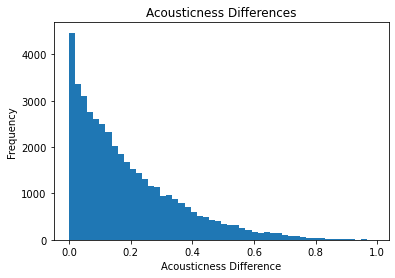

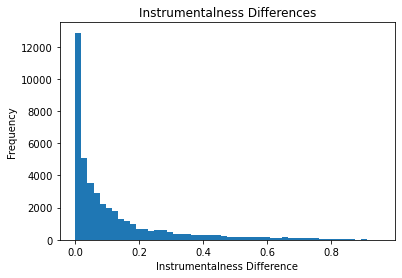

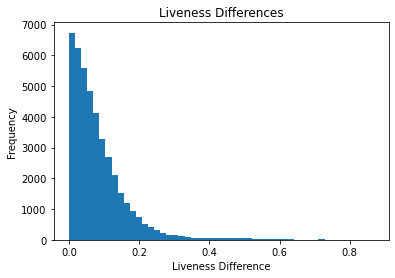

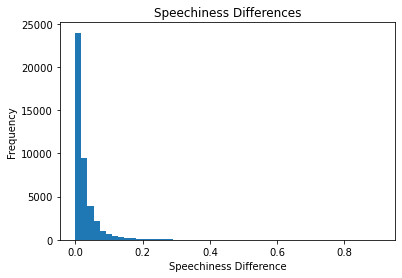

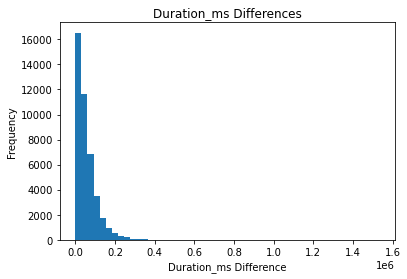

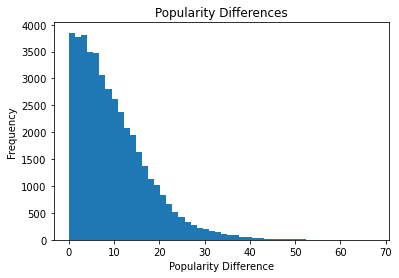

In [16]:
#If we want to analyze all the attributes at once
attribute_diffs = defaultdict(list)

for edge in G.edges(data=True):
    for attr in ["danceability", "energy", "valence", "tempo", "loudness",
                 "acousticness", "instrumentalness", "liveness", "speechiness",
                 "duration_ms", "popularity"]:
        attribute_diffs[attr].append(edge[2][attr + "_diff"])

# Plot histograms for each attribute
for attr, diffs in attribute_diffs.items():
    plt.hist(diffs, bins=50)
    plt.title(f'{attr.capitalize()} Differences')
    plt.xlabel(f'{attr.capitalize()} Difference')
    plt.ylabel('Frequency')
    plt.show()

Analyzing the distribution of the differences in musical characteristics between influencers and followers in the network can provide insights into various aspects of the influence relationship. Some of the information you can gather from the distribution includes:

Central tendency: You can identify the mean, median, or mode of the distribution, which can tell you the average difference in a musical characteristic between influencers and followers. This can help you understand the general trend in how much a particular characteristic changes when one artist influences another.

Dispersion: Measures like standard deviation, variance, or interquartile range can help you understand the spread of the differences in musical characteristics. A higher dispersion indicates that the influence varies greatly among artists, while a lower dispersion means that the influence is more consistent across the network.

Skewness: Skewness of the distribution can tell you if the differences are symmetric around the mean or if there is a tendency for the differences to be larger or smaller than the mean. This can give you insights into whether the influence is predominantly in one direction, i.e., increasing or decreasing a particular characteristic.

Outliers: By analyzing outliers in the distribution, you can identify specific influencer-follower pairs that show an unusually large or small difference in a musical characteristic. These outliers can be interesting cases to investigate further to understand unique influence patterns.

Distribution shape: The shape of the distribution can reveal underlying patterns in the data. For example, a bimodal distribution might suggest that there are two distinct groups of artists in the network with different influence patterns.

By examining the distribution of the differences in musical characteristics, you can gain a deeper understanding of how artists influence each other in terms of these characteristics. You can also identify potential patterns and trends that can be further analyzed to uncover the underlying mechanisms driving the influence.

Now let us rank the most influencing artists based on the average differences. 
The following code calculates the sum of the differences in energy, valence, and tempo for each influencer across all their followers. Then, it sorts the influencers based on this sum and selects the top 10 influencers with the smallest sum. Finally, it prints out the top 10 influencers along with their total difference value.

Please note that this is just an example that considers the differences in energy, valence, and tempo. We can modify the list of attributes in the code to include other musical characteristics if desired.

In [17]:
influencer_difference_sum = defaultdict(float)

for edge in G.edges(data=True):
    influencer_id = edge[0]
    total_diff = sum([edge[2][attr + "_diff"] for attr in ["energy", "valence", "tempo"]])
    influencer_difference_sum[influencer_id] += total_diff

# Sort the influencers by the sum of differences
sorted_influencers = sorted(influencer_difference_sum.items(), key=lambda x: x[1])

# Get the top 10 influencers
top_influencers = sorted_influencers[:10]

# Print the top 10 influencers
for influencer_id, total_diff in top_influencers:
    influencer_name = G.nodes[influencer_id]['artist_name']
    print(f"{influencer_name} (ID: {influencer_id}): Total difference = {total_diff}")


The West Coast Pop Art Experimental Band (ID: 482572): Total difference = 0.1693226180000057
JoaquÃ­n Sabina (ID: 143559): Total difference = 0.25610633700000496
Zedd (ID: 2782403): Total difference = 0.3524692490000058
Dallas Holm (ID: 567374): Total difference = 0.3922499659999962
Martin Gore (ID: 318966): Total difference = 0.40400000000000014
Paul Weston (ID: 29609): Total difference = 0.41942832600000046
Miles Davis Quintet (ID: 424302): Total difference = 0.47069420000000184
Stan Levey (ID: 6563): Total difference = 0.5241333629999855
Harry "Sweets" Edison (ID: 670641): Total difference = 0.5479224850000054
t.A.T.u. (ID: 1113): Total difference = 0.5828332999999994


Now how about top influencers in each musical charactersitcs.
 The following code calculates the sum of differences for each influencer and each musical characteristic (energy, valence, and tempo) separately. Then, it sorts the influencers for each attribute based on the sum of differences and selects the top 3 influencers with the smallest sum. Finally, it prints out the top 3 influencers for each attribute along with their total difference value.

Please note that this example considers the differences in energy, valence, and tempo. We can modify the list of attributes in the code to include other musical characteristics if desired.

In [18]:


# Initialize a dictionary to store the difference sums for each attribute
attribute_difference_sums = {attr: defaultdict(float) for attr in ["energy", "valence", "tempo"]}

# Calculate the sum of differences for each influencer and each attribute
for edge in G.edges(data=True):
    influencer_id = edge[0]
    for attr in attribute_difference_sums.keys():
        attribute_difference_sums[attr][influencer_id] += edge[2][f"{attr}_diff"]

# Get the top 3 influencers for each attribute
top_influencers_by_attribute = {
    attr: sorted(difference_sums.items(), key=lambda x: x[1])[:3]
    for attr, difference_sums in attribute_difference_sums.items()
}

# Print the top 3 influencers for each attribute
for attr, top_influencers in top_influencers_by_attribute.items():
    print(f"Top 3 influencers for {attr}:")
    for influencer_id, total_diff in top_influencers:
        influencer_name = G.nodes[influencer_id]['artist_name']
        print(f"  {influencer_name} (ID: {influencer_id}): Total {attr} difference = {total_diff}")


Top 3 influencers for energy:
  Bappi Lahiri (ID: 122037): Total energy difference = 0.0006666670000000652
  Mudvayne (ID: 509156): Total energy difference = 0.0012092729999999552
  Vengaboys (ID: 840708): Total energy difference = 0.00172222199999994
Top 3 influencers for valence:
  Freda Payne (ID: 796710): Total valence difference = 0.0002857139999999925
  Tracy Bonham (ID: 11046): Total valence difference = 0.0007657660000000011
  King Floyd (ID: 90169): Total valence difference = 0.0009090910000000285
Top 3 influencers for tempo:
  Martin Gore (ID: 318966): Total tempo difference = 0.006000000000000227
  Dallas Holm (ID: 567374): Total tempo difference = 0.023083299999996143
  JoaquÃ­n Sabina (ID: 143559): Total tempo difference = 0.0251793000000049


In [19]:
musical_characteristics = [
    'energy',
    'valence',
    'tempo',
    'loudness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'speechiness',
    'duration_ms',
    'popularity',
    'danceability'
]


genre_weight = 0.4
outside_genre_weight = 0.6

In [30]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


def train_linear_regression(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def train_ridge_regression(X_train, y_train):
    model = Ridge(alpha=0.1)
    model.fit(X_train, y_train)
    return model

def train_lasso_regression(X_train, y_train):
    model = Lasso(alpha=0.1)
    model.fit(X_train, y_train)
    return model

def train_elastic_net_regression(X_train, y_train):
    model = ElasticNet(alpha=0.1, l1_ratio=0.5)
    model.fit(X_train, y_train)
    return model

def train_bayesian_ridge_regression(X_train, y_train):
    model = BayesianRidge()
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse


In [31]:
# Generate the feature matrix and target vector
eigenvector_centrality_scores = nx.eigenvector_centrality(G)

# Initialize empty lists to store the features and labels for the regression models
features = []
labels = []

# Loop over each edge in the graph
for edge in G.edges(data=True):
    
    # Append the difference in musical characteristics for each attribute for the edge to the features list
    features.append([edge[2][attr + '_diff'] for attr in musical_characteristics])
    
    # Get the eigenvector centrality score for the influencer and follower nodes in the current edge
    influencer_centrality = eigenvector_centrality_scores[edge[0]]
    follower_centrality = eigenvector_centrality_scores[edge[1]]
    
    # Compute the average of the eigenvector centrality scores of the influencer and follower nodes and append it to the labels list
    labels.append((influencer_centrality + follower_centrality) / 2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train the regression models
models = {}
models['linear_regression'] = train_linear_regression(X_train, y_train)
models['ridge_regression'] = train_ridge_regression(X_train, y_train)
models['lasso_regression'] = train_lasso_regression(X_train, y_train)
models['elastic_net_regression'] = train_elastic_net_regression(X_train, y_train)
models['bayesian_ridge_regression'] = train_bayesian_ridge_regression(X_train, y_train)

# Evaluate the models and print the results
best_model = None
best_mse = float('inf')
for name, model in models.items():
    mse = evaluate_model(model, X_test, y_test)
    if mse < best_mse:
        best_model = model
        best_mse = mse
    print(f"{name} MSE: {mse}\n")

print(f"The best model is {type(best_model).__name__} with an MSE of {best_mse}")


linear_regression MSE: 0.00010998190671631953

ridge_regression MSE: 0.00010998188362657878

lasso_regression MSE: 0.00011366212490233118

elastic_net_regression MSE: 0.0001136619485143928

bayesian_ridge_regression MSE: 0.0001099813186497367

The best model is BayesianRidge with an MSE of 0.0001099813186497367


In [32]:
bayesian_ridge_regression_model = models['bayesian_ridge_regression']
coefficients = bayesian_ridge_regression_model.coef_

print("Model coefficients:")
for i, attr in enumerate(musical_characteristics):
    print(f"{attr}: {bayesian_ridge_regression_model.coef_[i]}")


Model coefficients:
energy: -0.00046625527617278977
valence: -0.0014859295598446086
tempo: 2.947519692278183e-05
loudness: -5.9851852434204516e-05
acousticness: -0.0104686383698309
instrumentalness: 0.0007636852509595757
liveness: -0.002470943015898268
speechiness: 0.003174801114960429
duration_ms: -7.491987838069065e-09
popularity: -3.98161342144303e-05
danceability: 3.565363734091189e-05


**Direction of research for this project:**
 We can aim to develop a model that computes an influence coefficient for each artist, taking into account the impact of musical attributes, as well as the influence within and across genres. By assigning weights to these factors, the model can emphasize certain aspects, such as giving more importance to influences outside the genre. Additionally, the model should determine the significance of specific musical attributes in measuring influence and assign appropriate weights to them.

Here is the code for one such model. In this example, the calculate_influence_coefficient function calculates the influence coefficient for a given artist based on the differences in musical characteristics, genre influence, and other factors. The influence coefficient is calculated as the sum of weighted differences in musical characteristics and genre influence.

Attribute weights, genre weights, and outside genre weights are defined separately. We can change these weights to emphasize different factors when calculating the influence coefficient. In this example, we assigned random weights to energy, valence, and tempo differences etc, and assigned more weight to the influence outside the genre than the influence within the genre.
Now we have to determine how we want to assign these weights. 


In [33]:
# Define a function to calculate the influence coefficient
def calculate_influence_coefficient(artist_id, G, attribute_weights, genre_weight, outside_genre_weight):
    influence_sum = 0
    total_weight = sum(attribute_weights.values()) + genre_weight + outside_genre_weight
    
    # Calculate the sum of weighted differences in musical characteristics
    for attr, weight in attribute_weights.items():
        attribute_diff = sum(edge[2][f"{attr}_diff"] for edge in G.out_edges(artist_id, data=True))
        influence_sum += (attribute_diff * weight)

    # Calculate the sum of weighted genre influence
    in_genre_influence = 0
    out_genre_influence = 0
    for edge in G.out_edges(artist_id, data=True):
        influencer_genre = G.nodes[artist_id]['genre']
        follower_genre = G.nodes[edge[1]]['genre']
        
        if influencer_genre == follower_genre:
            in_genre_influence += 1
        else:
            out_genre_influence += 1
            
    influence_sum += in_genre_influence * genre_weight
    influence_sum += out_genre_influence * outside_genre_weight

    return influence_sum / total_weight


# Define attribute weights, genre weights, and outside genre weights
attribute_weights = {
    'energy': -0.00046625527617278977,
    'valence': -0.0014859295598446086,
    'tempo': 2.947519692278183e-05,
    'loudness': -5.9851852434204516e-05,
    'acousticness': -0.0104686383698309,
    'instrumentalness': 0.0007636852509595757,
    'liveness': -0.002470943015898268,
    'speechiness': 0.003174801114960429,
    'duration_ms': -7.491987838069065e-09,
    'popularity': -3.98161342144303e-05,
    'danceability': 3.565363734091189e-05
}


genre_weight = 0.4
outside_genre_weight = 0.6

Now let us look at the artist with highest influence coeffients. 

In [34]:
# Calculate influence coefficients for each artist in the graph
influence_coefficients = {
    artist_id: calculate_influence_coefficient(
        artist_id, G, attribute_weights, genre_weight, outside_genre_weight
    )
    for artist_id in G.nodes()
}

# Find the top 5 artists with the highest influence coefficients
top_influencers = sorted(influence_coefficients.items(), key=lambda x: -x[1])[:5]

# Print the top 5 influencers
print("Top 5 influencers:")
for artist_id, influence_coefficient in top_influencers:
    artist_name = G.nodes[artist_id]['artist_name']
    print(f"  {artist_name} (ID: {artist_id}): Influence coefficient = {influence_coefficient}")

Top 5 influencers:
  The Beatles (ID: 754032): Influence coefficient = 258.71482727517974
  Bob Dylan (ID: 66915): Influence coefficient = 169.4891058289173
  The Rolling Stones (ID: 894465): Influence coefficient = 131.22363408890953
  David Bowie (ID: 531986): Influence coefficient = 98.51621120819806
  Hank Williams (ID: 549797): Influence coefficient = 91.14679515918382


In [35]:
# Generate the feature matrix and target vector
degree_centrality = nx.degree_centrality(G)


# Initialize empty lists to store the features and labels for the regression models
features = []
labels = []

# Loop over each edge in the graph
for edge in G.edges(data=True):
    
    # Append the difference in musical characteristics for each attribute for the edge to the features list
    features.append([edge[2][attr + '_diff'] for attr in musical_characteristics])
    
    # Get the degree_centrality  score for the influencer and follower nodes in the current edge
    influencer_centrality = degree_centrality[edge[0]]
    follower_centrality = degree_centrality[edge[1]]
    
    # Compute the average of the degree_centrality  scores of the influencer and follower nodes and append it to the labels list
    labels.append((influencer_centrality + follower_centrality) / 2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train the regression models
models = {}
models['linear_regression'] = train_linear_regression(X_train, y_train)
models['ridge_regression'] = train_ridge_regression(X_train, y_train)
models['lasso_regression'] = train_lasso_regression(X_train, y_train)
models['elastic_net_regression'] = train_elastic_net_regression(X_train, y_train)
models['bayesian_ridge_regression'] = train_bayesian_ridge_regression(X_train, y_train)

# Evaluate the models and print the results
best_model = None
best_mse = float('inf')
for name, model in models.items():
    mse = evaluate_model(model, X_test, y_test)
    if mse < best_mse:
        best_model = model
        best_mse = mse
    print(f"{name} MSE: {mse}\n")

print(f"The best model is {type(best_model).__name__} with an MSE of {best_mse}")


linear_regression MSE: 7.82076491305253e-05

ridge_regression MSE: 7.820773194804028e-05

lasso_regression MSE: 8.027883915369661e-05

elastic_net_regression MSE: 8.027872431049451e-05

bayesian_ridge_regression MSE: 7.82136853035515e-05

The best model is LinearRegression with an MSE of 7.82076491305253e-05


In [36]:
linear_regression_model = models['linear_regression']
coefficients = linear_regression_model.coef_

print("Model coefficients:")
for i, attr in enumerate(musical_characteristics):
    print(f"{attr}: {linear_regression_model.coef_[i]}")


Model coefficients:
energy: 0.0023710669364053146
valence: -0.002884575772075156
tempo: -6.715273627010535e-05
loudness: -0.00022712083693741486
acousticness: 0.0021801818130626847
instrumentalness: -0.0013841205224201028
liveness: -0.000521471131031451
speechiness: -0.012440177166873116
duration_ms: 2.0494953772293156e-09
popularity: -3.369627792196211e-05
danceability: -0.002819901102005813


In [37]:
attribute_weights = {
    'energy': 0.0023710669364053146,
    'valence': -0.002884575772075156,
    'tempo': -6.715273627010535e-05,
    'loudness': -0.00022712083693741486,
    'acousticness': 0.0021801818130626847,
    'instrumentalness': -0.0013841205224201028,
    'liveness': -0.000521471131031451,
    'speechiness': -0.012440177166873116,
    'duration_ms': 2.0494953772293156e-09,
    'popularity': -3.369627792196211e-05,
    'danceability': -0.002819901102005813
}


# Calculate influence coefficients for each artist in the graph
influence_coefficients = {
    artist_id: calculate_influence_coefficient(
        artist_id, G, attribute_weights, genre_weight, outside_genre_weight
    )
    for artist_id in G.nodes()
}

# Find the top 5 artists with the highest influence coefficients
top_influencers = sorted(influence_coefficients.items(), key=lambda x: -x[1])[:5]

# Print the top 5 influencers
print("Top 5 influencers:")
for artist_id, influence_coefficient in top_influencers:
    artist_name = G.nodes[artist_id]['artist_name']
    print(f"  {artist_name} (ID: {artist_id}): Influence coefficient = {influence_coefficient}")

Top 5 influencers:
  The Beatles (ID: 754032): Influence coefficient = 260.8397742985166
  Bob Dylan (ID: 66915): Influence coefficient = 171.0141754879616
  The Rolling Stones (ID: 894465): Influence coefficient = 132.0677630019937
  David Bowie (ID: 531986): Influence coefficient = 99.04018997674979
  Hank Williams (ID: 549797): Influence coefficient = 92.26899837216888


In [38]:
# Generate the feature matrix and target vector
betweenness_centrality = nx.betweenness_centrality(G)


# Initialize empty lists to store the features and labels for the regression models
features = []
labels = []

# Loop over each edge in the graph
for edge in G.edges(data=True):
    
    # Append the difference in musical characteristics for each attribute for the edge to the features list
    features.append([edge[2][attr + '_diff'] for attr in musical_characteristics])
    
    # Get the betweenness_centrality  score for the influencer and follower nodes in the current edge
    influencer_centrality = betweenness_centrality[edge[0]]
    follower_centrality = betweenness_centrality[edge[1]]
    
    # Compute the average of the betweenness_centrality  scores of the influencer and follower nodes and append it to the labels list
    labels.append((influencer_centrality + follower_centrality) / 2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train the regression models
models = {}
models['linear_regression'] = train_linear_regression(X_train, y_train)
models['ridge_regression'] = train_ridge_regression(X_train, y_train)
models['lasso_regression'] = train_lasso_regression(X_train, y_train)
models['elastic_net_regression'] = train_elastic_net_regression(X_train, y_train)
models['bayesian_ridge_regression'] = train_bayesian_ridge_regression(X_train, y_train)

# Evaluate the models and print the results
best_model = None
best_mse = float('inf')
for name, model in models.items():
    mse = evaluate_model(model, X_test, y_test)
    if mse < best_mse:
        best_model = model
        best_mse = mse
    print(f"{name} MSE: {mse}\n")

print(f"The best model is {type(best_model).__name__} with an MSE of {best_mse}")


linear_regression MSE: 4.173620512733798e-06

ridge_regression MSE: 4.1736240388151476e-06

lasso_regression MSE: 4.203909548119698e-06

elastic_net_regression MSE: 4.203890876923052e-06

bayesian_ridge_regression MSE: 4.1740432892387455e-06

The best model is LinearRegression with an MSE of 4.173620512733798e-06


In [39]:
linear_regression_model = models['linear_regression']
coefficients = linear_regression_model.coef_

print("Model coefficients:")
for i, attr in enumerate(musical_characteristics):
    print(f"{attr}: {linear_regression_model.coef_[i]}")


Model coefficients:
energy: 0.0006227855461225861
valence: -0.0003363972629988929
tempo: -9.781643039893679e-06
loudness: -4.024860435234554e-05
acousticness: 0.00014956978811953635
instrumentalness: -0.00010537086684372266
liveness: 0.0001049158885719073
speechiness: -0.00074395516560273
duration_ms: 6.287691049246258e-10
popularity: -1.593510017433036e-06
danceability: -0.00033375359192276623


In [40]:
attribute_weights = {
    'energy': 0.0006227855461225861,
    'valence': -0.0003363972629988929,
    'tempo': -9.781643039893679e-06,
    'loudness': -4.024860435234554e-05,
    'acousticness': 0.00014956978811953635,
    'instrumentalness': -0.00010537086684372266,
    'liveness': 0.0001049158885719073,
    'speechiness': -0.00074395516560273,
    'duration_ms': 6.287691049246258e-10,
    'popularity': -1.593510017433036e-06,
    'danceability': -0.00033375359192276623
}
# Calculate influence coefficients for each artist in the graph
influence_coefficients = {
    artist_id: calculate_influence_coefficient(
        artist_id, G, attribute_weights, genre_weight, outside_genre_weight
    )
    for artist_id in G.nodes()
}

# Find the top 5 artists with the highest influence coefficients
top_influencers = sorted(influence_coefficients.items(), key=lambda x: -x[1])[:5]

# Print the top 5 influencers
print("Top 5 influencers:")
for artist_id, influence_coefficient in top_influencers:
    artist_name = G.nodes[artist_id]['artist_name']
    print(f"  {artist_name} (ID: {artist_id}): Influence coefficient = {influence_coefficient}")

Top 5 influencers:
  The Beatles (ID: 754032): Influence coefficient = 257.88679695017163
  Bob Dylan (ID: 66915): Influence coefficient = 169.05758874978233
  The Rolling Stones (ID: 894465): Influence coefficient = 130.6283629452412
  David Bowie (ID: 531986): Influence coefficient = 98.01337036436769
  Hank Williams (ID: 549797): Influence coefficient = 91.04898724080472


In [41]:
# Generate the feature matrix and target vector
closeness_centrality = nx.closeness_centrality(G)

# Initialize empty lists to store the features and labels for the regression models
features = []
labels = []

# Loop over each edge in the graph
for edge in G.edges(data=True):
    
    # Append the difference in musical characteristics for each attribute for the edge to the features list
    features.append([edge[2][attr + '_diff'] for attr in musical_characteristics])
    
    # Get the closeness_centrality  score for the influencer and follower nodes in the current edge
    influencer_centrality = closeness_centrality[edge[0]]
    follower_centrality = closeness_centrality[edge[1]]
    
    # Compute the average of the closeness_centrality  scores of the influencer and follower nodes and append it to the labels list
    labels.append((influencer_centrality + follower_centrality) / 2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train the regression models
models = {}
models['linear_regression'] = train_linear_regression(X_train, y_train)
models['ridge_regression'] = train_ridge_regression(X_train, y_train)
models['lasso_regression'] = train_lasso_regression(X_train, y_train)
models['elastic_net_regression'] = train_elastic_net_regression(X_train, y_train)
models['bayesian_ridge_regression'] = train_bayesian_ridge_regression(X_train, y_train)

# Evaluate the models and print the results
best_model = None
best_mse = float('inf')
for name, model in models.items():
    mse = evaluate_model(model, X_test, y_test)
    if mse < best_mse:
        best_model = model
        best_mse = mse
    print(f"{name} MSE: {mse}\n")

print(f"The best model is {type(best_model).__name__} with an MSE of {best_mse}")


linear_regression MSE: 0.0003705662366186016

ridge_regression MSE: 0.00037056640089723486

lasso_regression MSE: 0.00038992170214096467

elastic_net_regression MSE: 0.0003899210143318324

bayesian_ridge_regression MSE: 0.0003705768928447644

The best model is LinearRegression with an MSE of 0.0003705662366186016


In [42]:
linear_regression_model = models['linear_regression']
coefficients = linear_regression_model.coef_

print("Model coefficients:")
for i, attr in enumerate(musical_characteristics):
    print(f"{attr}: {linear_regression_model.coef_[i]}")


Model coefficients:
energy: 0.0018293399956577409
valence: 0.002458208423549258
tempo: 7.18630852091306e-05
loudness: 0.0001759061567017887
acousticness: -0.024921592440657763
instrumentalness: -0.0007702424117844492
liveness: -0.0031312429591417576
speechiness: -0.011616477847427559
duration_ms: -2.3299444962786298e-08
popularity: -0.00019910317157314334
danceability: 0.00693600298896803


In [43]:
attribute_weights = {
    'energy': 0.0018293399956577409,
    'valence': 0.002458208423549258,
    'tempo': 7.18630852091306e-05,
    'loudness': 0.0001759061567017887,
    'acousticness': -0.024921592440657763,
    'instrumentalness': -0.0007702424117844492,
    'liveness': -0.0031312429591417576,
    'speechiness': -0.011616477847427559,
    'duration_ms': -2.3299444962786298e-08,
    'popularity': -0.00019910317157314334,
    'danceability': 0.00693600298896803
}
# Calculate influence coefficients for each artist in the graph
influence_coefficients = {
    artist_id: calculate_influence_coefficient(
        artist_id, G, attribute_weights, genre_weight, outside_genre_weight
    )
    for artist_id in G.nodes()
}

# Find the top 5 artists with the highest influence coefficients
top_influencers = sorted(influence_coefficients.items(), key=lambda x: -x[1])[:5]

# Print the top 5 influencers
print("Top 5 influencers:")
for artist_id, influence_coefficient in top_influencers:
    artist_name = G.nodes[artist_id]['artist_name']
    print(f"  {artist_name} (ID: {artist_id}): Influence coefficient = {influence_coefficient}")


Top 5 influencers:
  The Beatles (ID: 754032): Influence coefficient = 261.29366698337316
  Bob Dylan (ID: 66915): Influence coefficient = 171.07665429979096
  The Rolling Stones (ID: 894465): Influence coefficient = 132.9000910908746
  David Bowie (ID: 531986): Influence coefficient = 99.94142030234534
  Jimi Hendrix (ID: 354105): Influence coefficient = 92.09736662634008


In [44]:
# Generate the feature matrix and target vector
katz_centrality = nx.katz_centrality(G)

# Initialize empty lists to store the features and labels for the regression models
features = []
labels = []

# Loop over each edge in the graph
for edge in G.edges(data=True):
    
    # Append the difference in musical characteristics for each attribute for the edge to the features list
    features.append([edge[2][attr + '_diff'] for attr in musical_characteristics])
    
    # Get the katz_centrality  score for the influencer and follower nodes in the current edge
    influencer_centrality = katz_centrality[edge[0]]
    follower_centrality = katz_centrality[edge[1]]
    
    # Compute the average of the katz_centrality  scores of the influencer and follower nodes and append it to the labels list
    labels.append((influencer_centrality + follower_centrality) / 2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train the regression models
models = {}
models['linear_regression'] = train_linear_regression(X_train, y_train)
models['ridge_regression'] = train_ridge_regression(X_train, y_train)
models['lasso_regression'] = train_lasso_regression(X_train, y_train)
models['elastic_net_regression'] = train_elastic_net_regression(X_train, y_train)
models['bayesian_ridge_regression'] = train_bayesian_ridge_regression(X_train, y_train)

# Evaluate the models and print the results
best_model = None
best_mse = float('inf')
for name, model in models.items():
    mse = evaluate_model(model, X_test, y_test)
    if mse < best_mse:
        best_model = model
        best_mse = mse
    print(f"{name} MSE: {mse}\n")

print(f"The best model is {type(best_model).__name__} with an MSE of {best_mse}")


linear_regression MSE: 0.00011666454423285746

ridge_regression MSE: 0.0001166645853772013

lasso_regression MSE: 0.00012456035933722703

elastic_net_regression MSE: 0.00012456017190215114

bayesian_ridge_regression MSE: 0.00011666687561259164

The best model is LinearRegression with an MSE of 0.00011666454423285746


In [45]:
linear_regression_model = models['linear_regression']
coefficients = linear_regression_model.coef_

print("Model coefficients:")
for i, attr in enumerate(musical_characteristics):
    print(f"{attr}: {linear_regression_model.coef_[i]}")


Model coefficients:
energy: 0.0007862071685311271
valence: -0.0013889140729908803
tempo: 1.9534837027405493e-05
loudness: -6.490965860913955e-06
acousticness: -0.015929306753644665
instrumentalness: 0.002083420063186647
liveness: -0.0026491099547547147
speechiness: -0.0057259337518057955
duration_ms: -1.1446582566347618e-08
popularity: -9.306248082885641e-05
danceability: 0.0007646835230197874


In [46]:
attribute_weights = {
    'energy': 0.0007862071685311271,
    'valence': -0.0013889140729908803,
    'tempo': 1.9534837027405493e-05,
    'loudness': -6.490965860913955e-06,
    'acousticness': -0.015929306753644665,
    'instrumentalness': 0.002083420063186647,
    'liveness': -0.0026491099547547147,
    'speechiness': -0.0057259337518057955,
    'duration_ms': -1.1446582566347618e-08,
    'popularity': -9.306248082885641e-05,
    'danceability': 0.0007646835230197874
}
# Calculate influence coefficients for each artist in the graph
influence_coefficients = {
    artist_id: calculate_influence_coefficient(
        artist_id, G, attribute_weights, genre_weight, outside_genre_weight
    )
    for artist_id in G.nodes()
}

# Find the top 5 artists with the highest influence coefficients
top_influencers = sorted(influence_coefficients.items(), key=lambda x: -x[1])[:5]

# Print the top 5 influencers
print("Top 5 influencers:")
for artist_id, influence_coefficient in top_influencers:
    artist_name = G.nodes[artist_id]['artist_name']
    print(f"  {artist_name} (ID: {artist_id}): Influence coefficient = {influence_coefficient}")


Top 5 influencers:
  The Beatles (ID: 754032): Influence coefficient = 260.6132125652726
  Bob Dylan (ID: 66915): Influence coefficient = 170.66100897268012
  The Rolling Stones (ID: 894465): Influence coefficient = 132.31507391219262
  David Bowie (ID: 531986): Influence coefficient = 99.36491604523454
  Hank Williams (ID: 549797): Influence coefficient = 91.73587890925847


### Calculating the weights
Above, we just used random weights. But we have to figure out these weights in a systematic fashion. To determine the appropriate weights for each attribute and influence type, we could conduct a data-driven analysis of the relationships between these factors and an artist's influence. **This analysis could involve techniques such as linear regression, correlation analysis, or machine learning models** .

One approach would be to use a subset of the data to train a model that predicts an artist's influence based on their musical characteristics and genre influences, and then use this model to determine the optimal weights for each factor. We could also experiment with different weight combinations and evaluate their performance using metrics such as R-squared or mean absolute error.

Another approach would be to consult with experts in the music industry and gather their insights on the relative importance of different musical characteristics and influence types. This approach may involve qualitative research methods such as interviews or surveys. May be do literature review regarding this? 

**Maybe use statistics from netowrk anlysis like betweeness centrality, eigenvector centrality etc in some way to figure out the weithts**. No matter which method is used **Conduct sensitivity analysis** must be done. We can test the influence coefficient calculation with different weightings for the attributes or factors and observe the impact on the results. This approach can help us understand the sensitivity of the model to the weightings and choose the best combination based on your desired outcomes.

In [47]:
attribute_weights_list = [
    {
        'energy': -0.00046625527617278977,
        'valence': -0.0014859295598446086,
        'tempo': 2.947519692278183e-05,
        'loudness': -5.9851852434204516e-05,
        'acousticness': -0.0104686383698309,
        'instrumentalness': 0.0007636852509595757,  #eigenvector centrality
        'liveness': -0.002470943015898268,
        'speechiness': 0.003174801114960429,
        'duration_ms': -7.491987838069065e-09,
        'popularity': -3.98161342144303e-05,
        'danceability': 3.565363734091189e-05
    },
    {
        'energy': 0.0023710669364053146,
        'valence': -0.002884575772075156,
        'tempo': -6.715273627010535e-05,
        'loudness': -0.00022712083693741486,
        'acousticness': 0.0021801818130626847,  #degree centrality
        'instrumentalness': -0.0013841205224201028,
        'liveness': -0.000521471131031451,
        'speechiness': -0.012440177166873116,
        'duration_ms': 2.0494953772293156e-09,
        'popularity': -3.369627792196211e-05,
        'danceability': -0.002819901102005813
    },
    {
        'energy': 0.0006227855461225861,
        'valence': -0.0003363972629988929,
        'tempo': -9.781643039893679e-06,
        'loudness': -4.024860435234554e-05,
        'acousticness': 0.00014956978811953635,
        'instrumentalness': -0.00010537086684372266,    #betweenness_centrality
        'liveness': 0.0001049158885719073,
        'speechiness': -0.00074395516560273,
        'duration_ms': 6.287691049246258e-10,
        'popularity': -1.593510017433036e-06,
        'danceability': -0.00033375359192276623
    },
    {
        'energy': 0.0018293399956577409,
        'valence': 0.002458208423549258,
        'tempo': 7.18630852091306e-05,
        'loudness': 0.0001759061567017887,
        'acousticness': -0.024921592440657763,
        'instrumentalness': -0.0007702424117844492, #closeness centrality
        'liveness': -0.0031312429591417576,
        'speechiness': -0.011616477847427559,
        'duration_ms': -2.3299444962786298e-08,
        'popularity': -0.00019910317157314334,
        'danceability': 0.00693600298896803
    }, 
    {
        'energy': 0.0007862071685311271,
        'valence': -0.0013889140729908803,
        'tempo': 1.9534837027405493e-05,
        'loudness': -6.490965860913955e-06,
        'acousticness': -0.015929306753644665,  #katz centrality
        'instrumentalness': 0.002083420063186647,
        'liveness': -0.0026491099547547147,
        'speechiness': -0.0057259337518057955,
        'duration_ms': -1.1446582566347618e-08,
        'popularity': -9.306248082885641e-05,
        'danceability': 0.0007646835230197874      
    }
]


In [48]:
from prettytable import PrettyTable

for i in range(len(attribute_weights_list)):
    sorted_keys = sorted(attribute_weights_list[i], key=lambda x: abs(attribute_weights_list[i][x]), reverse=True)
    table = PrettyTable()
    table.field_names = ["Rank", "Attribute"]
    for rank, key in enumerate(sorted_keys):
        table.add_row([rank+1, key])
    table.align["Rank"] = "c"
    table.align["Attribute"] = "l"
    print(f"Ranking for index {i+1}:\n{table}\n")


Ranking for index 1:
+------+------------------+
| Rank | Attribute        |
+------+------------------+
|  1   | acousticness     |
|  2   | speechiness      |
|  3   | liveness         |
|  4   | valence          |
|  5   | instrumentalness |
|  6   | energy           |
|  7   | loudness         |
|  8   | popularity       |
|  9   | danceability     |
|  10  | tempo            |
|  11  | duration_ms      |
+------+------------------+

Ranking for index 2:
+------+------------------+
| Rank | Attribute        |
+------+------------------+
|  1   | speechiness      |
|  2   | valence          |
|  3   | danceability     |
|  4   | energy           |
|  5   | acousticness     |
|  6   | instrumentalness |
|  7   | liveness         |
|  8   | loudness         |
|  9   | tempo            |
|  10  | popularity       |
|  11  | duration_ms      |
+------+------------------+

Ranking for index 3:
+------+------------------+
| Rank | Attribute        |
+------+------------------+
|  1   | sp

**Potential direction**

Suppose we have a network of musicians and their collaborations, where the edges represent collaborations between musicians and the nodes represent musicians. We also have information about the musical characteristics of each musician's songs, such as energy, valence, tempo, etc.

By analyzing this network, we can calculate each musician's influence coefficient, as we discussed earlier. We can also calculate various network centrality measures, such as degree centrality, betweenness centrality, and eigenvector centrality, which can help us identify central nodes in the network.

Furthermore, we can use network analysis tools to identify clusters or communities within the network, which are groups of nodes that are more densely connected to each other than to the rest of the network. These clusters can help us identify subgroups of musicians that have similar musical characteristics or collaborate more frequently with each other.

By examining the relationships between musical characteristics and network structure, we can identify which characteristics are more important in determining influence. For example, if we find that musicians with higher energy levels tend to have higher influence coefficients and also tend to be more central in the network, we might conclude that energy is an important factor in determining influence in this network.

In summary, network analysis can help us gain insights into the relationship between musical characteristics and influence, as well as the overall structure of the network and the role of different nodes within it.

#### Method 1

**IDEAS**

1. First look at the distribution of musical characterstics and different centrality measures. 
2. Find the relationship between them calculating differnt correlation statistics. 
3. Rank the importance of muscial characterstics for each centrality measure. 
4. May be combine information from all centrality mesures to come up with one ranking?

We could calculate degree centrality, betweenness centrality, or eigenvector centrality, and plot them against the values of different musical characteristics like energy or valence. This can help identify nodes or clusters that may be more influential or central in the network and explore how they relate to different musical characteristics.

In [50]:

# # Degree centrality
# degree_centrality = nx.degree_centrality(G)

# # Betweenness centrality
# betweenness_centrality = nx.betweenness_centrality(G)

# # Eigenvector centrality
# eigenvector_centrality = nx.eigenvector_centrality(G)

# # Closeness centrality
# closeness_centrality = nx.closeness_centrality(G)

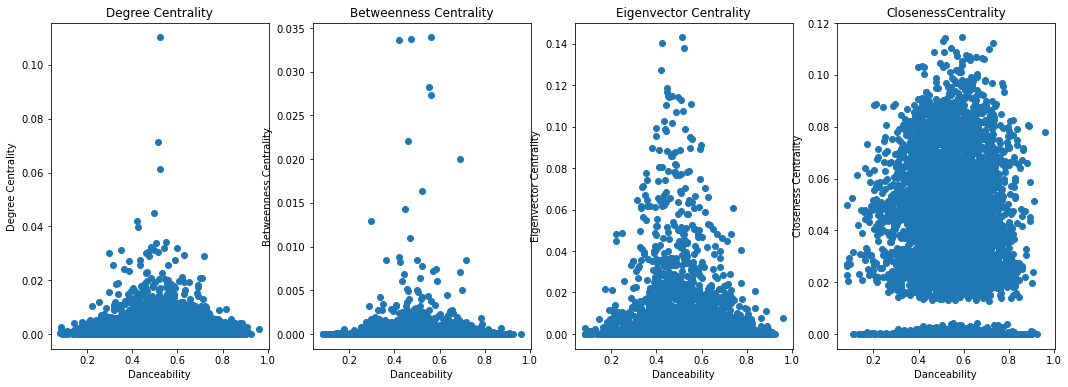

In [ ]:
#attribute_names = ['danceability', 'energy', 'valence', 'tempo', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']
#using the full list might take long time so try using one
attribute_names = ['danceability']

# Calculate and plot different centrality measures against musical characteristics
fig, ax = plt.subplots(1, 4, figsize=(18,6))

# Degree centrality
for i, attr in enumerate(attribute_names):
    attr_values = defaultdict(list)
    for n, v in degree_centrality.items():
        attr_values[attr].append(G.nodes[n][attr])
    ax[0].scatter(attr_values[attr], list(degree_centrality.values()))
    ax[0].set_title('Degree Centrality')
    ax[0].set_xlabel(attr.capitalize())
    ax[0].set_ylabel('Degree Centrality')


# Betweenness centrality
for i, attr in enumerate(attribute_names):
    attr_values = defaultdict(list)
    for n, v in betweenness_centrality.items():
        attr_values[attr].append(G.nodes[n][attr])
    ax[1].scatter(attr_values[attr], list(betweenness_centrality.values()))
    ax[1].set_title('Betweenness Centrality')
    ax[1].set_xlabel(attr.capitalize())
    ax[1].set_ylabel('Betweenness Centrality')

# Eigenvector centrality
for i, attr in enumerate(attribute_names):
    attr_values = defaultdict(list)
    for n, v in eigenvector_centrality.items():
        attr_values[attr].append(G.nodes[n][attr])
    ax[2].scatter(attr_values[attr], list(eigenvector_centrality.values()))
    ax[2].set_title('Eigenvector Centrality')
    ax[2].set_xlabel(attr.capitalize())
    ax[2].set_ylabel('Eigenvector Centrality')

# Closeness centrality
for i, attr in enumerate(attribute_names):
    attr_values = defaultdict(list)
    for n, v in closeness_centrality.items():
        attr_values[attr].append(G.nodes[n][attr])
    ax[3].scatter(attr_values[attr], list(closeness_centrality.values()))
    ax[3].set_title('ClosenessCentrality')
    ax[3].set_xlabel(attr.capitalize())
    ax[3].set_ylabel('Closeness Centrality')

plt.show()



If we look at the distribution, it is not linear. So in order to study their relationship linear correlation coefficients won't be sufficient. First let us look at each musical charactersitcs and their correlations with betweenness centrality. Later we will include others too. 

In [51]:
from scipy.stats import spearmanr, kendalltau, pearsonr

attribute_names = ['danceability', 'energy', 'valence', 'tempo', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']

for attr in attribute_names:
    bc_values = []
    attr_values = []
    for node in G.nodes():
        bc_values.append(betweenness_centrality[node])
        attr_values.append(G.nodes[node][attr])
    spearman_corr, _ = spearmanr(bc_values, attr_values)
    kendall_corr, _ = kendalltau(bc_values, attr_values)
    pearson_corr, _ = pearsonr(bc_values, attr_values)
    
    # Create a dictionary with correlation coefficients and their names
    corr_dict = {'Spearman': spearman_corr, 'Kendall': kendall_corr, 'Pearson': pearson_corr}
    
    # Sort the dictionary by the absolute value of the correlation coefficient
    sorted_corr_dict = {k: v for k, v in sorted(corr_dict.items(), key=lambda item: abs(item[1]), reverse=True)}
    
    # Print the correlations and their rankings
    print(f"\n{attr.capitalize()}:")
    for i, (corr_name, corr_value) in enumerate(sorted_corr_dict.items()):
        print(f"{i+1}. {corr_name} correlation: {corr_value:.2f}")





Danceability:
1. Spearman correlation: -0.08
2. Kendall correlation: -0.06
3. Pearson correlation: -0.03

Energy:
1. Spearman correlation: -0.05
2. Kendall correlation: -0.04
3. Pearson correlation: -0.02

Valence:
1. Spearman correlation: 0.03
2. Kendall correlation: 0.02
3. Pearson correlation: 0.00

Tempo:
1. Spearman correlation: 0.03
2. Kendall correlation: 0.02
3. Pearson correlation: 0.00

Loudness:
1. Spearman correlation: -0.16
2. Kendall correlation: -0.11
3. Pearson correlation: -0.04

Acousticness:
1. Spearman correlation: 0.04
2. Kendall correlation: 0.03
3. Pearson correlation: 0.03

Instrumentalness:
1. Spearman correlation: 0.20
2. Kendall correlation: 0.14
3. Pearson correlation: -0.00

Liveness:
1. Spearman correlation: 0.11
2. Kendall correlation: 0.08
3. Pearson correlation: 0.02

Speechiness:
1. Spearman correlation: 0.01
2. Pearson correlation: -0.01
3. Kendall correlation: 0.01


Now let's modify the code to print the ranking of musical characteristics for each correlation type (Spearman, Kendall, and Pearson), with the characteristics that have the strongest correlation ranked first.

In [52]:
from scipy.stats import spearmanr, kendalltau, pearsonr

attribute_names = ['danceability', 'energy', 'valence', 'tempo', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']
correlations = {}

for attr_name in attribute_names:
    # Get betweenness centrality values and attribute values for each node
    bc_values = []
    attr_values = []
    for node in G.nodes():
        bc_values.append(betweenness_centrality[node])
        attr_values.append(G.nodes[node][attr_name])
    # Calculate Spearman, Kendall, and Pearson correlations
    spearman_corr, _ = spearmanr(bc_values, attr_values)
    kendall_corr, _ = kendalltau(bc_values, attr_values)
    pearson_corr, _ = pearsonr(bc_values, attr_values)
    correlations[attr_name] = {'Spearman': spearman_corr, 'Kendall': kendall_corr, 'Pearson': pearson_corr}

# Sort correlations by descending order of Spearman correlation
sorted_correlations = sorted(correlations.items(), key=lambda x: x[1]['Spearman'], reverse=True)

# Print rankings for each correlation type
for corr_type in ['Spearman', 'Kendall', 'Pearson']:
    print(f"\nRanking by {corr_type} correlation:")
    rank = 1
    for attr, corr_dict in sorted_correlations:
        corr_val = corr_dict[corr_type]
        print(f"{rank}. {attr.capitalize()} - {corr_type} correlation: {corr_val:.2f}")
        rank += 1



Ranking by Spearman correlation:
1. Instrumentalness - Spearman correlation: 0.20
2. Liveness - Spearman correlation: 0.11
3. Acousticness - Spearman correlation: 0.04
4. Valence - Spearman correlation: 0.03
5. Tempo - Spearman correlation: 0.03
6. Speechiness - Spearman correlation: 0.01
7. Energy - Spearman correlation: -0.05
8. Danceability - Spearman correlation: -0.08
9. Loudness - Spearman correlation: -0.16

Ranking by Kendall correlation:
1. Instrumentalness - Kendall correlation: 0.14
2. Liveness - Kendall correlation: 0.08
3. Acousticness - Kendall correlation: 0.03
4. Valence - Kendall correlation: 0.02
5. Tempo - Kendall correlation: 0.02
6. Speechiness - Kendall correlation: 0.01
7. Energy - Kendall correlation: -0.04
8. Danceability - Kendall correlation: -0.06
9. Loudness - Kendall correlation: -0.11

Ranking by Pearson correlation:
1. Instrumentalness - Pearson correlation: -0.00
2. Liveness - Pearson correlation: 0.02
3. Acousticness - Pearson correlation: 0.03
4. Val

The above output gives us a much better understanding of which musical characterstics are important for betweenness centrality. We can see that Instrumentalness is top for all types of correlation statistics. Now we shall do the same thing but for other centralities. 

In [54]:
#for eigenvector centrality

attribute_names = ['danceability', 'energy', 'valence', 'tempo', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']
correlations = {}

for attr_name in attribute_names:
    # Get eigenvector centrality values and attribute values for each node
    bc_values = []
    attr_values = []
    for node in G.nodes():
        bc_values.append(eigenvector_centrality_scores[node])
        attr_values.append(G.nodes[node][attr_name])
    # Calculate Spearman, Kendall, and Pearson correlations
    spearman_corr, _ = spearmanr(bc_values, attr_values)
    kendall_corr, _ = kendalltau(bc_values, attr_values)
    pearson_corr, _ = pearsonr(bc_values, attr_values)
    correlations[attr_name] = {'Spearman': spearman_corr, 'Kendall': kendall_corr, 'Pearson': pearson_corr}

# Sort correlations by descending order of Spearman correlation
sorted_correlations = sorted(correlations.items(), key=lambda x: x[1]['Spearman'], reverse=True)

# Print rankings for each correlation type
for corr_type in ['Spearman', 'Kendall', 'Pearson']:
    print(f"\nRanking by {corr_type} correlation:")
    rank = 1
    for attr, corr_dict in sorted_correlations:
        corr_val = corr_dict[corr_type]
        print(f"{rank}. {attr.capitalize()} - {corr_type} correlation: {corr_val:.2f}")
        rank += 1



Ranking by Spearman correlation:
1. Loudness - Spearman correlation: 0.48
2. Energy - Spearman correlation: 0.47
3. Tempo - Spearman correlation: 0.20
4. Speechiness - Spearman correlation: 0.04
5. Liveness - Spearman correlation: 0.04
6. Instrumentalness - Spearman correlation: -0.05
7. Danceability - Spearman correlation: -0.10
8. Valence - Spearman correlation: -0.20
9. Acousticness - Spearman correlation: -0.52

Ranking by Kendall correlation:
1. Loudness - Kendall correlation: 0.34
2. Energy - Kendall correlation: 0.33
3. Tempo - Kendall correlation: 0.14
4. Speechiness - Kendall correlation: 0.02
5. Liveness - Kendall correlation: 0.03
6. Instrumentalness - Kendall correlation: -0.04
7. Danceability - Kendall correlation: -0.07
8. Valence - Kendall correlation: -0.14
9. Acousticness - Kendall correlation: -0.38

Ranking by Pearson correlation:
1. Loudness - Pearson correlation: 0.31
2. Energy - Pearson correlation: 0.28
3. Tempo - Pearson correlation: 0.11
4. Speechiness - Pears

In [ ]:
#for closeness centrality

attribute_names = ['danceability', 'energy', 'valence', 'tempo', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']
correlations = {}

for attr_name in attribute_names:
    # Get closeness centrality values and attribute values for each node
    bc_values = []
    attr_values = []
    for node in G.nodes():
        bc_values.append(closeness_centrality[node])
        attr_values.append(G.nodes[node][attr_name])
    # Calculate Spearman, Kendall, and Pearson correlations
    spearman_corr, _ = spearmanr(bc_values, attr_values)
    kendall_corr, _ = kendalltau(bc_values, attr_values)
    pearson_corr, _ = pearsonr(bc_values, attr_values)
    correlations[attr_name] = {'Spearman': spearman_corr, 'Kendall': kendall_corr, 'Pearson': pearson_corr}

# Sort correlations by descending order of Spearman correlation
sorted_correlations = sorted(correlations.items(), key=lambda x: x[1]['Spearman'], reverse=True)

# Print rankings for each correlation type
for corr_type in ['Spearman', 'Kendall', 'Pearson']:
    print(f"\nRanking by {corr_type} correlation:")
    rank = 1
    for attr, corr_dict in sorted_correlations:
        corr_val = corr_dict[corr_type]
        print(f"{rank}. {attr.capitalize()} - {corr_type} correlation: {corr_val:.2f}")
        rank += 1


Ranking by Spearman correlation:
1. Loudness - Spearman correlation: 0.47
2. Energy - Spearman correlation: 0.43
3. Tempo - Spearman correlation: 0.19
4. Liveness - Spearman correlation: 0.03
5. Speechiness - Spearman correlation: 0.01
6. Danceability - Spearman correlation: -0.06
7. Instrumentalness - Spearman correlation: -0.08
8. Valence - Spearman correlation: -0.20
9. Acousticness - Spearman correlation: -0.48

Ranking by Kendall correlation:
1. Loudness - Kendall correlation: 0.33
2. Energy - Kendall correlation: 0.30
3. Tempo - Kendall correlation: 0.13
4. Liveness - Kendall correlation: 0.02
5. Speechiness - Kendall correlation: 0.01
6. Danceability - Kendall correlation: -0.04
7. Instrumentalness - Kendall correlation: -0.05
8. Valence - Kendall correlation: -0.13
9. Acousticness - Kendall correlation: -0.34

Ranking by Pearson correlation:
1. Loudness - Pearson correlation: 0.44
2. Energy - Pearson correlation: 0.41
3. Tempo - Pearson correlation: 0.15
4. Liveness - Pearson 